# Introduction
In the previous part of the project, I created a models that succeeds in identifying 95% of the plant species based on its spectral reflectance from a hyperspectral camera ([link to part 1](https://github.com/yehuda-yu/Image_processing/blob/main/HyperSpectral_Image_Proccesing/HS_Pixel_Classification_Project/Pixel_Classification_Project.ipynb)).

In this part, I want to **run the models on a whole image and do segmentation for every pixel in the image**. The final product will be a map of the different species on the green wall.

In [1]:
!pip install spectral
import spectral.io.envi as envi
from pathlib import Path
from spectral import *
import matplotlib.pyplot as plt
import skimage.io as io
from skimage import transform
import skimage
import numpy as np
import pandas as pd
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 26.2 MB/s 


## **Nueral Network Segmentation**

### 1. Read HS image and prepre it to the model

In [2]:
path = '/content/drive/MyDrive/Greenwall/HyperSpectral_images/merged/28_07_2022.hdr'
img = open_image(path)
print(img)

	Data Source:   '/content/drive/MyDrive/Greenwall/HyperSpectral_images/merged/28_07_2022.img'
	# Rows:            512
	# Samples:         807
	# Bands:           204
	Interleave:        BIP
	Quantization:  32 bits
	Data format:   float32


Present RGB bands of the image

ImageView object:
  Display bands       :  (98, 53, 30)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.002745098201557994, 1.0666208267211914]
    G: [0.0037464320193976164, 1.041091799736023]
    B: [0.0036420393735170364, 1.042359709739685]

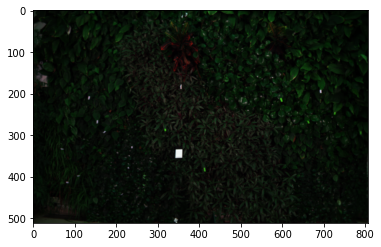

In [3]:
imshow(img,(98,53,30))

array of wavelenghs for columns of df:

In [4]:
wl = [397.32, 400.2, 403.09, 405.97, 408.85, 411.74, 414.63, 417.52, 420.4, 423.29, 426.19, 429.08, 431.97, 434.87, 437.76, 440.66, 443.56, 446.45, 449.35, 452.25, 455.16, 458.06, 460.96, 463.87, 466.77, 469.68, 472.59, 475.5, 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 498.8, 501.72, 504.64, 507.56, 510.48, 513.4, 516.33, 519.25, 522.18, 525.1, 528.03, 530.96, 533.89, 536.82, 539.75, 542.68, 545.62, 548.55, 551.49, 554.43, 557.36, 560.3, 563.24, 566.18, 569.12, 572.07, 575.01, 577.96, 580.9, 583.85, 586.8, 589.75, 592.7, 595.65, 598.6, 601.55, 604.51, 607.46, 610.42, 613.38, 616.34, 619.3, 622.26, 625.22, 628.18, 631.15, 634.11, 637.08, 640.04, 643.01, 645.98, 648.95, 651.92, 654.89, 657.87, 660.84, 663.81, 666.79, 669.77, 672.75, 675.73, 678.71, 681.69, 684.67, 687.65, 690.64, 693.62, 696.61, 699.6, 702.58, 705.57, 708.57, 711.56, 714.55, 717.54, 720.54, 723.53, 726.53, 729.53, 732.53, 735.53, 738.53, 741.53, 744.53, 747.54, 750.54, 753.55, 756.56, 759.56, 762.57, 765.58, 768.6, 771.61, 774.62, 777.64, 780.65, 783.67, 786.68, 789.7, 792.72, 795.74, 798.77, 801.79, 804.81, 807.84, 810.86, 813.89, 816.92, 819.95, 822.98, 826.01, 829.04, 832.07, 835.11, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 865.5, 868.55, 871.6, 874.64, 877.69, 880.74, 883.79, 886.84, 889.9, 892.95, 896.01, 899.06, 902.12, 905.18, 908.24, 911.3, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 938.88, 941.95, 945.02, 948.1, 951.17, 954.24, 957.32, 960.4, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22, 994.31, 997.4, 1000.49, 1003.58]

Since the model I trained is built to receive a two-dimensional array I need to **reshape the image to 2D array**. i will create a DataFrame from the image. Every column will be a band and every row will be a pixel.

In [5]:
y = img[:,:,:].shape[0] # y axis
x = img[:,:,:].shape[1] # x axis
z = img[:,:,:].shape[2] # z axis (bands)
a = img[:,:,:].reshape(x*y,z)  #Reshape to 2D array
df = pd.DataFrame(a, columns=wl) #Convert to df
df.columns

Float64Index([ 397.32,   400.2,  403.09,  405.97,  408.85,  411.74,  414.63,
               417.52,   420.4,  423.29,
              ...
               975.79,  978.88,  981.96,  985.05,  988.13,  991.22,  994.31,
                997.4, 1000.49, 1003.58],
             dtype='float64', length=204)

Delete noisy columns. More info in [part 1](https://github.com/yehuda-yu/Image_processing/blob/main/HyperSpectral_Image_Proccesing/HS_Pixel_Classification_Project/Pixel_Classification_Project.ipynb)

In [6]:
# delete the noisy columns
first_columns_drop = 6
ends_column_drop = -22
df = df.iloc[: , first_columns_drop:] #drop the 6 first columns
df = df.iloc[: , :ends_column_drop] # drop the last 22 columns
df.columns

Float64Index([414.63, 417.52,  420.4, 423.29, 426.19, 429.08, 431.97, 434.87,
              437.76, 440.66,
              ...
              908.24,  911.3, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68,
              932.74, 935.81],
             dtype='float64', length=176)

Convert to numpy array:
In some of the models I used **standardization** so that the data needs to be normalized

In [13]:
norm_df = (df-df.mean())/df.std()
numpy_df = np.array(norm_df)
# numpy_df

### **Load the model and evalute**

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

Restoring the network I built in part A:

In [14]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 1000) #input = num_feature, output=512
        self.layer_2 = nn.Linear(1000, 1000)
        self.layer_3 = nn.Linear(1000,512)
        self.layer_out = nn.Linear(512, num_class) 
        
        self.relu = nn.ReLU() #Relu activation function
        self.dropout = nn.Dropout(p=0.2) #Dropout for avoid overfit
        self.batchnorm1 = nn.BatchNorm1d(1000) # Batch normalization
        self.batchnorm2 = nn.BatchNorm1d(1000)
        self.batchnorm3 = nn.BatchNorm1d(512)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Run on GPU
print(device) 
num_features = len(df.columns) #how much features we have (bands)
model = MulticlassClassification(num_feature = num_features , num_class=6) # hyperparameters
model.to(device)

Loss = nn.CrossEntropyLoss() #loss function 
optimizer = optim.Adam(model.parameters(), lr=0.0005) #Optimization and learning rate for the learning.
print(model)

cuda:0
MulticlassClassification(
  (layer_1): Linear(in_features=176, out_features=1000, bias=True)
  (layer_2): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_3): Linear(in_features=1000, out_features=512, bias=True)
  (layer_out): Linear(in_features=512, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Load the parameters to the network:

In [15]:
# Load
model.load_state_dict(torch.load("/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/Models/ANN_90%"))
model.eval()

MulticlassClassification(
  (layer_1): Linear(in_features=176, out_features=1000, bias=True)
  (layer_2): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_3): Linear(in_features=1000, out_features=512, bias=True)
  (layer_out): Linear(in_features=512, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Predict the species in 

In [16]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    pred = numpy_df
    pred = torch.from_numpy(pred).float()
    pred = pred.to(device)
    y_test_pred = model(pred)
    _, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze() for a in y_pred_list]

Reshape the predicted array to the original image shape

In [17]:
prediction_map = np.array(y_pred_list).reshape(img[:,:,:].shape[0],img[:,:,:].shape[1])

Present the prediction on the original image:

1. Create RGB image from the HS image.
2. Enhance the brightness of the RGB.
3. Present the RGB +prediction map.

In [18]:
red = img[:,:,97] #red band
green = img[:,:,53] # green band
blue = img[:,:,30] # blue band

# 3 bands into new image
RGB_Image = np.dstack([red,green,blue])# RGB  color composite

The original image is in low light. We will create an RGB image and make it bright. After that we will again present the map with plants that we created on top of the bright image

In [19]:
from PIL import Image, ImageEnhance
from keras.preprocessing.image import array_to_img

# COnvert array to image:
RGB_Image = array_to_img(RGB_Image)

#image brightness enhancer
enhancer = ImageEnhance.Brightness(RGB_Image)


factor = 3 #brightens the image
RGB_Image = enhancer.enhance(factor)
# im_output.save('brightened-image.png')

Present the results:

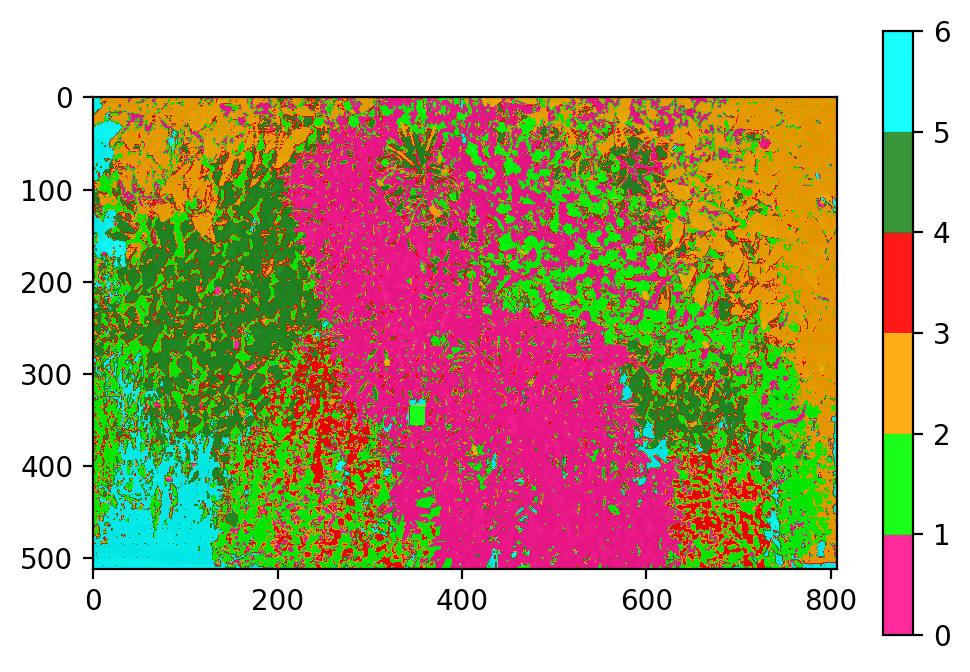

In [20]:
# Create cmap for presentation:

import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["deeppink","lime","Orange","red","forestgreen","cyan"])
bounds=[0,1,2,3,4,5,6] #bounds of colorbar
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Graph
fig = plt.figure( dpi = 200 )
ax  = plt.subplot(111)
plt.imshow(RGB_Image) # RGB image 
plt.imshow(prediction_map,cmap = cmap,alpha=0.9,norm=norm) # prediction image
plt.colorbar()

### **Remove Non-plant pixels based on NDVI**

In [21]:
red = 97 #680 nm band 97
nir = 140 # 810 nm band 140

Apply the *ndvi function* of the Spectral library:

In [22]:
NDVI = ndvi(img[:,:,:], red, nir)

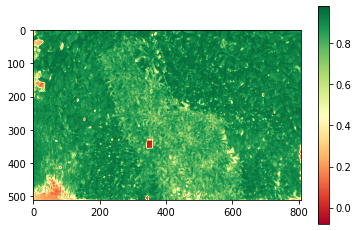

In [23]:
plt.imshow(NDVI,cmap="RdYlGn")
plt.colorbar()

Apply mask based on the distribution:

(array([2.0000e+00, 8.0000e+00, 1.2000e+01, 1.4000e+01, 1.0000e+01,
        1.8000e+01, 3.7000e+01, 1.4600e+02, 6.6000e+01, 1.8000e+01,
        3.5000e+01, 2.1000e+01, 2.2000e+01, 1.8000e+01, 2.7000e+01,
        3.3000e+01, 5.2000e+01, 7.0000e+01, 1.1700e+02, 1.3700e+02,
        1.2600e+02, 1.3100e+02, 1.4700e+02, 1.8400e+02, 2.0800e+02,
        2.3700e+02, 2.9300e+02, 3.2700e+02, 2.7000e+02, 2.9800e+02,
        2.7600e+02, 3.3400e+02, 2.7900e+02, 2.4700e+02, 2.6900e+02,
        2.6900e+02, 2.6200e+02, 2.2000e+02, 1.9700e+02, 1.9600e+02,
        1.6200e+02, 1.6100e+02, 1.9400e+02, 1.7300e+02, 1.8700e+02,
        1.9000e+02, 2.1200e+02, 2.2200e+02, 2.4300e+02, 2.2800e+02,
        2.1800e+02, 2.4400e+02, 2.5300e+02, 2.7300e+02, 2.6300e+02,
        3.2100e+02, 3.2700e+02, 3.6000e+02, 4.0000e+02, 4.5600e+02,
        4.8600e+02, 5.6200e+02, 5.7900e+02, 7.0400e+02, 6.5100e+02,
        7.6200e+02, 8.9100e+02, 1.0270e+03, 1.1690e+03, 1.3400e+03,
        1.5760e+03, 1.7260e+03, 2.0070e+03, 2.40

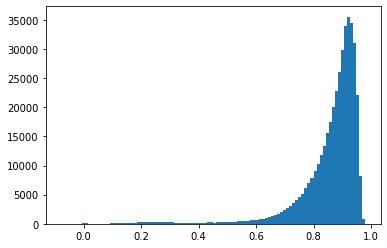

In [24]:
plt.hist(NDVI.flatten(),bins=100)

Create a Binary mask of plant/not plant based on NDVI:

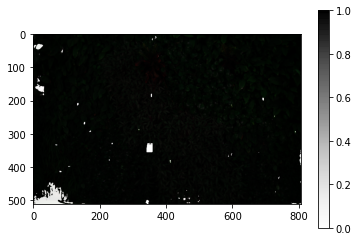

In [25]:
mask_ndvi = np.where(NDVI > 0.3 , NDVI, 0) # Replace all values < 0.3 with 0
mask_ndvi = np.where(mask_ndvi < 0.3 , mask_ndvi, 1) #Replace all values > 0.3 with 1
plt.imshow(RGB_Image)
# plt.colorbar()
plt.imshow(mask_ndvi,cmap="Greys",alpha=.9)
plt.colorbar()

Applt the mask on the prediction map:

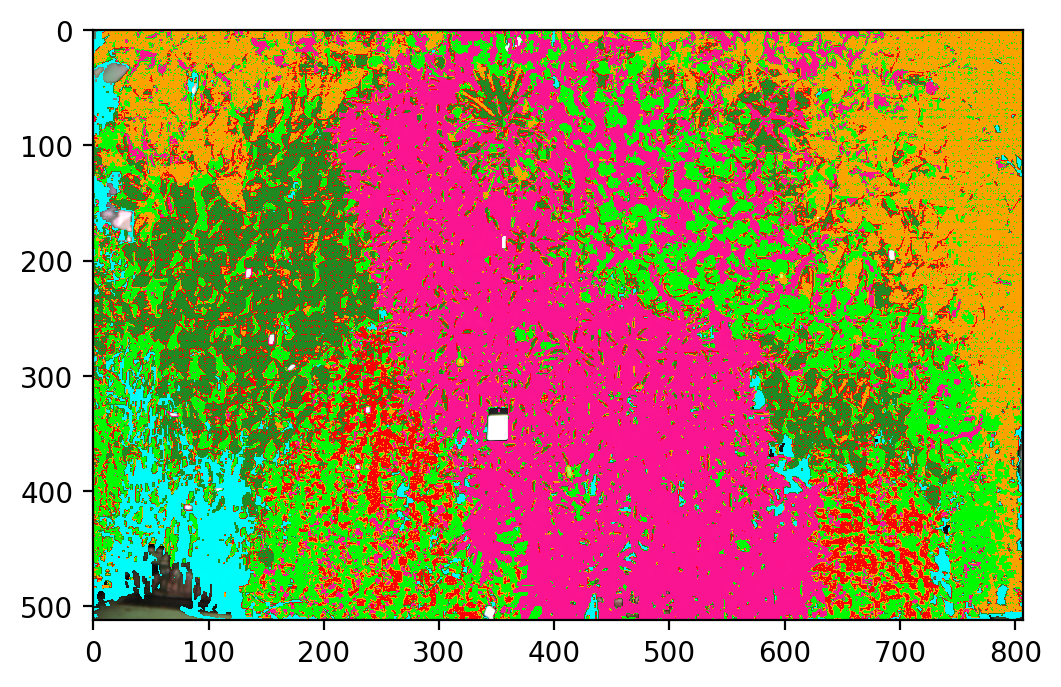

In [26]:
# Graph and colorbar:
fig = plt.figure( dpi = 200 )
bounds=[0,1,2,3,4,5,6]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
ax  = plt.subplot(111)
# Calculate the new mask:
# mask_map = mask
mask_map = np.where(mask_ndvi == 0, np.nan, prediction_map) # replace every pixel that the ndvi =0 nan
# Show on graph:
plt.imshow(RGB_Image)
plt.imshow(mask_map,cmap=cmap,norm = norm,alpha=.99)
# plt.colorbar()

## **Random Forest Segmentation**

Load the model:

In [27]:
# # If you want to load the model and predict new data:
with open("/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/Models/RF", "rb") as f:
  loaded_model = pickle.load(f) #load the model

In [28]:
rf_prediction = loaded_model.predict(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Convert the prediction array from plant name to number

In [29]:
labels_dict = {
    'Tradescantia':0,
    'Peperomia':1,
    'Spathiphyllum':2,
    'Monalisa':3,
    'Philodendron':4,
    'Chlorophytum':5
    }

In [30]:
# df of prediction-> replace values to numbers by the dict -> convert to float array
df_results_rf = pd.DataFrame(rf_prediction).replace(labels_dict).astype(float) 
predictions = df_results_rf.values
predictions

array([[5.],
       [5.],
       [5.],
       ...,
       [5.],
       [5.],
       [5.]])

Convert the the image shape:

In [31]:
prediction_map_rf = predictions.reshape(img[:,:,:].shape[0],img[:,:,:].shape[1])
prediction_map_rf.shape

(512, 807)

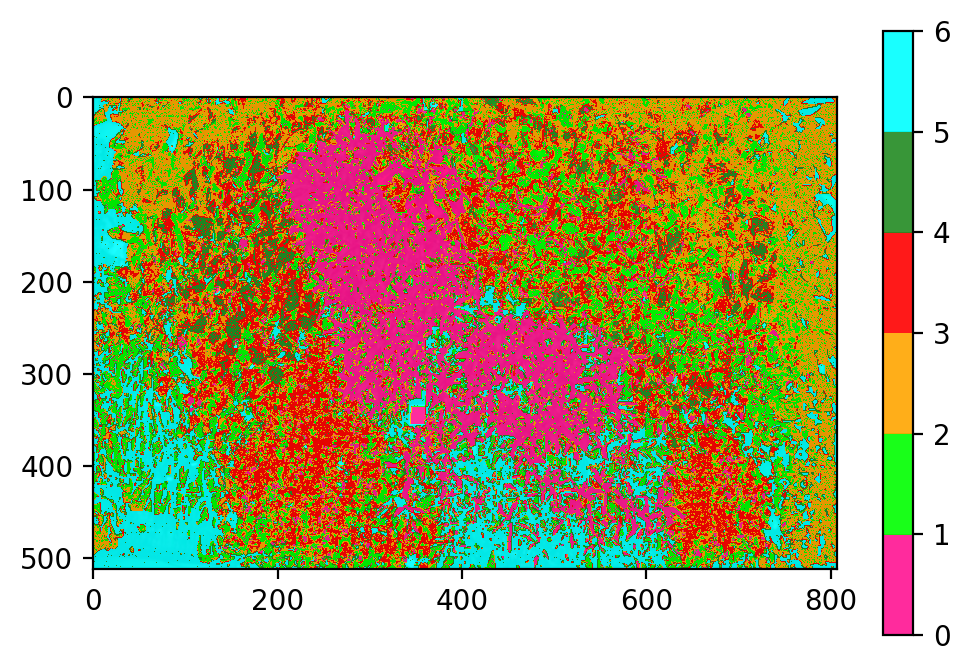

In [32]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["deeppink","lime","Orange","red","forestgreen","cyan"])
bounds=[0,1,2,3,4,5,6] #bounds of colorbar
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Graph
fig = plt.figure( dpi = 200 )
ax  = plt.subplot(111)
plt.imshow(RGB_Image) # RGB image 
plt.imshow(prediction_map_rf,cmap = cmap,alpha=0.9,norm=norm) # prediction image
plt.colorbar()

Remove the Non-plant pixels

In [33]:
def ndvi_remover(image, ndvi_thresh, prediction_array):
    NDVI = ndvi(image[:,:,:], 97, 140) #create ndvi image
  # mask based on NDVI htreshold:
    mask_ndvi = np.where(NDVI > ndvi_thresh , NDVI, 0) # Replace all values < thresh with 0
    mask_ndvi = np.where(mask_ndvi < ndvi_thresh , mask_ndvi, 1) #Replace all values > thresh with 1
  # mask of ndvi on the original image
    mask_map = np.where(mask_ndvi == 0, np.nan, prediction_array) # replace every pixel that the ndvi =0 nan

    return mask_map

In [34]:
rd_after_ndvi = ndvi_remover(img,0.3,prediction_map_rf)

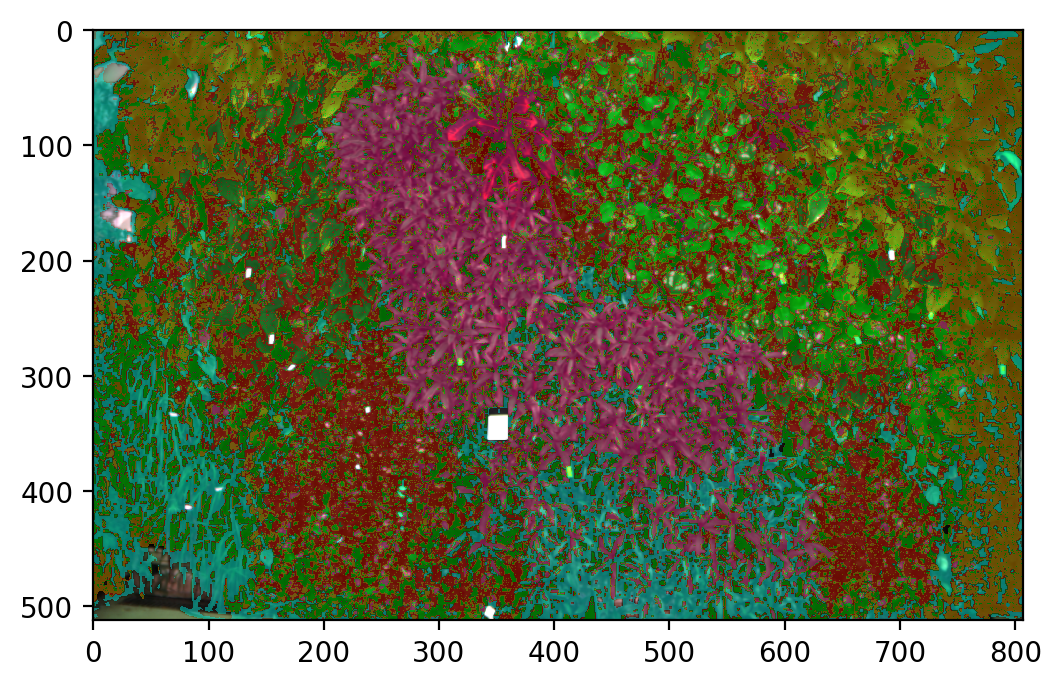

In [35]:
# Graph
fig = plt.figure( dpi = 200 )
ax  = plt.subplot(111)
plt.imshow(RGB_Image) # RGB image 
plt.imshow(rd_after_ndvi,cmap = cmap,alpha=0.5,norm=norm) # prediction image
# plt.colorbar()

## Logistic Regression

In [36]:
# # If you want to load the model and predict new data:
with open("/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/Models/Logistic_Reg", "rb") as f:
  loaded_logreg = pickle.load(f) #load the model

In [37]:
logreg_prediction = loaded_logreg.predict((df-df.mean())/df.std())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [38]:
labels_dict = {
    'Tradescantia':0,
    'Peperomia':1,
    'Spathiphyllum':2,
    'Monalisa':3,
    'Philodendron':4,
    'Chlorophytum':5
    }

In [39]:
# df of prediction-> replace values to numbers by the dict -> convert to float array
df_results_logreg = pd.DataFrame(logreg_prediction).replace(labels_dict).astype(float) 
predictions_lr = df_results_logreg.values
predictions_lr

array([[5.],
       [5.],
       [5.],
       ...,
       [5.],
       [5.],
       [5.]])

In [40]:
prediction_map_lr = predictions_lr.reshape(img[:,:,:].shape[0],img[:,:,:].shape[1])
prediction_map_lr.shape

(512, 807)

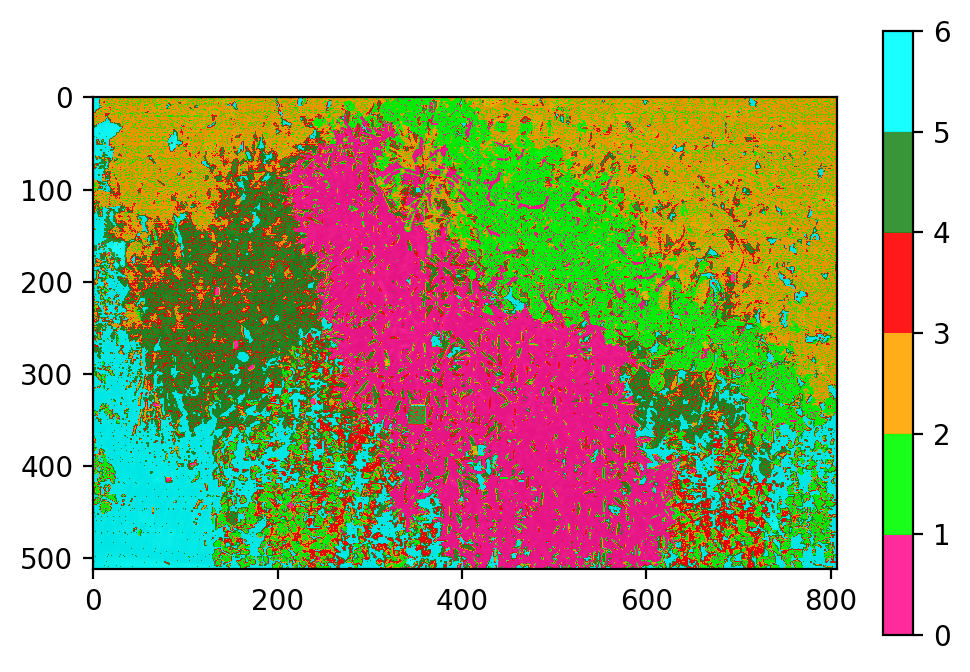

In [41]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["deeppink","lime","Orange","red","forestgreen","cyan"])
bounds=[0,1,2,3,4,5,6] #bounds of colorbar
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Graph
fig = plt.figure( dpi = 200 )
ax  = plt.subplot(111)
plt.imshow(RGB_Image) # RGB image 
plt.imshow(prediction_map_lr,cmap = cmap,alpha=0.9,norm=norm) # prediction image
plt.colorbar()

In [35]:
lr_after_ndvi = ndvi_remover(img,0.3,prediction_map_lr)

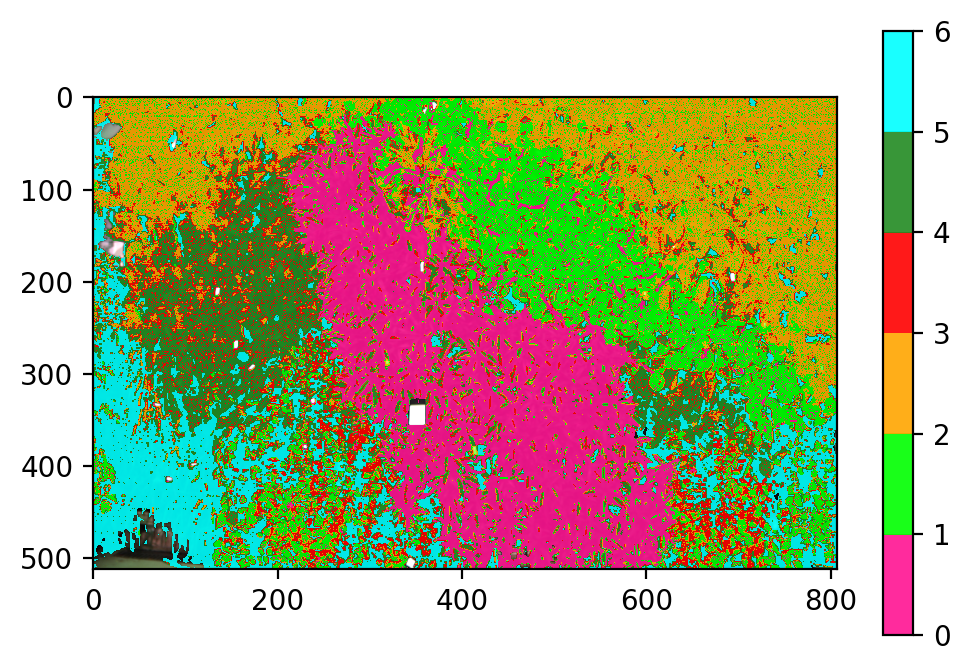

In [36]:
# Graph
fig = plt.figure( dpi = 200 )
ax  = plt.subplot(111)
plt.imshow(RGB_Image) # RGB image 
plt.imshow(lr_after_ndvi,cmap = cmap,alpha=0.9,norm=norm) # prediction image
plt.colorbar()